# First version of AE with clustering loss

## Import useful modules

In [1]:
!pip install scanpy
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip3 install igraph
!pip3 install leidenalg
!pip install os
!pip install csv
!pip install scvelo

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement csv (from versions: none

In [2]:
from keras import layers
from keras.layers import Layer
from keras.models import load_model, Model
from keras import backend as K
from keras.losses import KLDivergence
import numpy as np
import scanpy as sc
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from layers import ConstantDispersionLayer, SliceLayer, ColWiseMultLayer
import keras
from keras.layers import Layer
from sklearn.model_selection import train_test_split
import datetime
import time
import os
import csv
from scipy.optimize import linear_sum_assignment as linear_assignment
import scvelo

2024-06-08 17:27:18.721905: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 17:27:19.531085: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 17:27:20.246401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 17:27:29.380411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.__version__

'2.16.1'

In [4]:
keras.__version__

'3.3.3'

## Preprocessing

### Load dataset

On importe le dataset baron et on applique le prétraitement habituel

In [5]:
data_ann=scvelo.datasets.pbmc68k(file_path='data/PBMC/pbmc68k.h5ad')
data_ann

AnnData object with n_obs × n_vars = 65877 × 33939
    obs: 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_tsne'
    layers: 'spliced', 'unspliced'

In [6]:
data_ann.X.shape

(65877, 33939)

In [7]:
data_ann.obs.columns=['label']

In [8]:
data_ann.obs['label'].value_counts()

label
CD8+ Cytotoxic T                19941
CD8+/CD45RA+ Naive Cytotoxic    16032
CD56+ NK                         8440
CD4+/CD25 T Reg                  5921
CD19+ B                          5674
CD4+/CD45RO+ Memory              2945
CD14+ Monocyte                   2749
Dendritic                        2014
CD4+/CD45RA+/CD25- Naive T       1802
CD34+                             267
CD4+ T Helper2                     92
Name: count, dtype: int64

### Filter data

In [9]:
data_ann.var["mt"] = data_ann.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    data_ann, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
data_ann = data_ann[data_ann.obs.pct_counts_mt < 10, :].copy()

On filtre les données de manière peu stricte

In [10]:
sc.pp.filter_cells(data_ann, min_genes=1)
sc.pp.filter_genes(data_ann, min_cells=1)

In [11]:
data_ann.raw = data_ann.copy()

In [12]:
data_ann.raw.X

<65734x16116 sparse matrix of type '<class 'numpy.float32'>'
	with 7099119 stored elements in Compressed Sparse Row format>

In [13]:
data_ann

AnnData object with n_obs × n_vars = 65734 × 16116
    obs: 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    obsm: 'X_tsne'
    layers: 'spliced', 'unspliced'

### Normalize and scale

In [14]:
sc.pp.normalize_total(data_ann)
data_ann.obs['size_factors'] = data_ann.obs.n_genes / np.median(data_ann.obs.n_genes)
#data_ann.obs['size_factors'] = 1.0
sc.pp.log1p(data_ann)


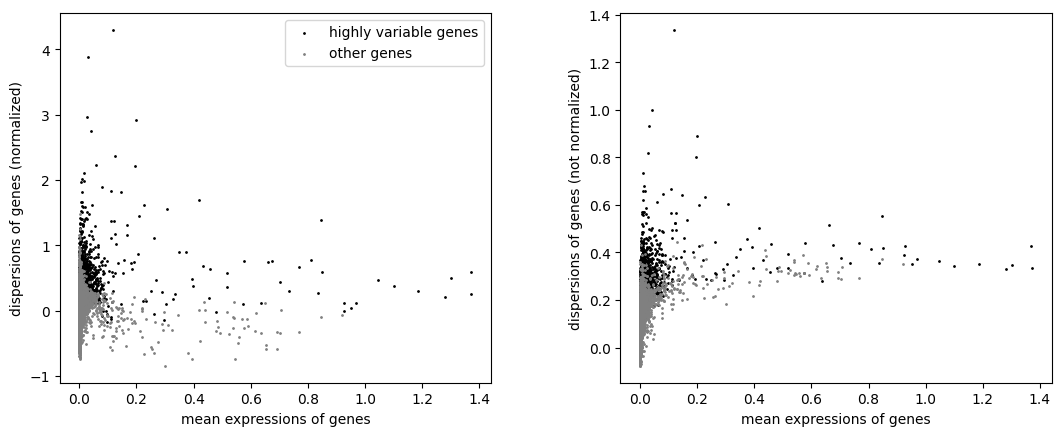

In [15]:
sc.pp.highly_variable_genes(data_ann, n_top_genes=2000, batch_key="label")
sc.pl.highly_variable_genes(data_ann)

In [16]:
sc.pp.scale(data_ann)

### Explore the result

In [17]:
data_ann.X

array([[-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036],
       [-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036],
       [-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036],
       ...,
       [-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036],
       [-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036],
       [-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036]], dtype=float32)

In [18]:
data_ann.n_vars

16116

In [19]:
data_ann.X

array([[-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036],
       [-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036],
       [-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036],
       ...,
       [-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036],
       [-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036],
       [-0.01407031, -0.00778552, -0.07102378, ..., -0.11460464,
        -0.05551179, -0.00390036]], dtype=float32)

In [20]:
data_ann.var

,Accession,Chromosome,End,Start,Strand,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mean,std
Gene,,,,,,,,,,,,,,,,,,,
LINC00115,ENSG00000225880,1,827522,826206,-,False,15,0.000258,99.977230,17.0,15,False,0.000516,0.194016,0.263935,2,False,0.000180,0.012821
FAM41C,ENSG00000230368,1,876903,868071,-,False,4,0.000061,99.993928,4.0,4,False,0.000040,-0.008447,-0.139974,0,False,0.000042,0.005335
NOC2L,ENSG00000188976,1,959309,944203,-,False,342,0.005298,99.480851,349.0,342,True,0.006384,0.130372,0.039965,4,False,0.003718,0.052355
AL645608.7,ENSG00000272512,1,998051,995966,-,False,5,0.000091,99.992410,6.0,5,False,0.000183,0.018101,-0.067974,1,False,0.000061,0.007095
HES4,ENSG00000188290,1,1000172,998962,-,False,123,0.001989,99.813288,131.0,122,False,0.005642,0.122236,0.114427,3,False,0.001513,0.036353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FUNDC2,ENSG00000165775,X,155060304,155025980,+,False,1100,0.017199,98.330221,1133.0,1099,True,0.016710,0.284415,0.390537,5,False,0.011995,0.093975
BRCC3,ENSG00000185515,X,155123074,155071420,+,False,114,0.001761,99.826950,116.0,113,False,0.001833,0.065218,-0.282746,0,False,0.001215,0.029590
VBP1,ENSG00000155959,X,155239817,155197007,+,False,877,0.013647,98.668731,899.0,877,False,0.012012,0.173895,0.036427,2,False,0.009510,0.082977


In [21]:
data_ann.obs

,label,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,size_factors
AAACATACACCCAA,CD8+ Cytotoxic T,125,166.0,4.0,2.409638,125,1.126126
AAACATACCCCTCA,CD8+/CD45RA+ Naive Cytotoxic,118,169.0,2.0,1.183432,118,1.063063
AAACATACCGGAGA,CD4+/CD45RO+ Memory,105,141.0,3.0,2.127660,105,0.945946
AAACATACTAACCG,CD19+ B,63,71.0,1.0,1.408451,63,0.567568
AAACATACTCTTCA,CD4+/CD25 T Reg,112,163.0,6.0,3.680982,112,1.009009
...,...,...,...,...,...,...,...
TTTGCATGAGCCTA,CD8+ Cytotoxic T,100,145.0,1.0,0.689655,100,0.900901
TTTGCATGCTAGCA,CD8+/CD45RA+ Naive Cytotoxic,83,109.0,2.0,1.834862,83,0.747748
TTTGCATGCTGCAA,CD8+ Cytotoxic T,110,143.0,1.0,0.699301,110,0.990991
TTTGCATGGCTCCT,CD8+ Cytotoxic T,98,132.0,2.0,1.515152,98,0.882883


In [22]:
data_ann.raw.X

<65734x16116 sparse matrix of type '<class 'numpy.float32'>'
	with 7099119 stored elements in Compressed Sparse Row format>

In [23]:
highly_variable_genes = data_ann.var[data_ann.var['highly_variable']].index.tolist()
count_data_hvg = data_ann[:, highly_variable_genes].X
count_data_hvg=count_data_hvg.toarray()
count_data_hvg

array([[-0.07102378, -0.05735018, -0.06802843, ..., -0.12842883,
        -0.12764187, -0.05551179],
       [-0.07102378, -0.05735018, -0.06802843, ..., -0.12842883,
        -0.12764187, -0.05551179],
       [-0.07102378, -0.05735018, -0.06802843, ..., -0.12842883,
        -0.12764187, -0.05551179],
       ...,
       [-0.07102378, -0.05735018, -0.06802843, ..., -0.12842883,
        -0.12764187, -0.05551179],
       [-0.07102378, -0.05735018, -0.06802843, ..., -0.12842883,
        -0.12764187, -0.05551179],
       [-0.07102378, -0.05735018, -0.06802843, ..., -0.12842883,
        -0.12764187, -0.05551179]], dtype=float32)

In [24]:
raw_count_hvg=data_ann.raw[:,highly_variable_genes].X

In [25]:
raw_count_hvg.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Create autoencoder

In [26]:
def negative_binomial_loss(y_true, y_pred):
    input_shape=int(y_pred.shape[1]/3)
    mu = y_pred[:, :input_shape]
    pi = y_pred[:, input_shape:input_shape*2]
    theta = y_pred[:, input_shape*2:]
    y_true = tf.cast(y_true, dtype='float32')
    #print(type(mu), mu)
    #print(type(pi),pi)
    #print(type(theta), theta)
    #print(type(y_true), y_true)


    eps = 1e-10
    t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
    t2 = (theta+y_true) * tf.math.log(1.0 + (mu/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(mu+eps)))
    final=t1 + t2
    final = tf.reduce_mean(final)
    return final

def zero_inflated_negative_binomial_loss(y_true, y_pred):
    input_shape=int(y_pred.shape[1]/3)
    mu = y_pred[:, :input_shape]
    pi = y_pred[:, input_shape:input_shape*2]
    theta = y_pred[:, input_shape*2:]
    y_true = tf.cast(y_true, dtype='float32')
    #print(type(mu), mu)
    #print(type(pi),pi)
    #print(type(theta), theta)
    #print(type(y_true), y_true)


    eps = 1e-10
    t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
    t2 = (theta+y_true) * tf.math.log(1.0 + (mu/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(mu+eps)))
    final=t1 + t2

    nb_case = t1 + t2 - tf.math.log(1.0-pi+eps)
    zero_nb = tf.pow(theta/(theta+mu+eps), theta)
    zero_case = -tf.math.log(pi + ((1.0-pi)*zero_nb)+eps)
    result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
    #ridge = self.ridge_lambda*tf.square(self.pi)
    #result += ridge
    result = tf.reduce_mean(result)
    return result

MeanAct = lambda x: tf.clip_by_value(tf.keras.backend.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.keras.backend.softplus(x), 1e-4, 1e4)

ColWiseMultLayer = lambda name: layers.Lambda(lambda l: l[0]*(tf.matmul(tf.reshape(l[1], (-1,1)),
                                                                 tf.ones((1, l[0].get_shape()[1]),
                                                                         dtype=l[1].dtype))), name=name)

In [27]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters=n_clusters
        self.alpha=alpha
        self.intial_weights=weights
        #self.input_spec=keras.InputSpec(ndim=2) #to specify the expected rank of the input

    def build(self, input_shape):
        input_dim=input_shape[1]
        #self.input_spec=keras.InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform')
        if self.intial_weights is not None :
            self.set_weights(self.intial_weights)
            del self.intial_weights
        self.built=True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (tf.math.reduce_sum(tf.math.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = tf.transpose(tf.transpose(q) / tf.math.reduce_sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [28]:
def create_autoencoder(input_shape, noise):
    init='glorot_uniform'
    Inputs = layers.Input(shape=(input_shape,), name='Inputs')
    sf_layer=layers.Input(shape=(1,), name="size_factors")
    x=layers.GaussianNoise(noise)(Inputs)
    x=layers.Dense(256, activation='relu',kernel_initializer=init, name='encoder_1' )(x)
    x=layers.GaussianNoise(noise)(x)
    x=layers.Dense(64, activation='relu',kernel_initializer=init, name='encoder_2' )(x)
    x=layers.GaussianNoise(noise)(x)
    hidden=layers.Dense(32, activation='relu',kernel_initializer=init, name='encoder_3' )(x)


    x=layers.Dense(32, activation='relu',kernel_initializer=init, name='decoder_1' )(hidden)
    x=layers.Dense(64, activation='relu',kernel_initializer=init, name='decoder_2' )(x)
    x=layers.Dense(256, activation='relu',kernel_initializer=init, name='decoder_3' )(x)
    pi=layers.Dense(input_shape, activation="sigmoid",kernel_initializer=init, name='pi')(x)
    disp=layers.Dense(input_shape, activation=DispAct,kernel_initializer=init, name='dispersion')(x)
    mean=layers.Dense(input_shape, activation=MeanAct,kernel_initializer=init, name='mean')(x)

    Outputs=ColWiseMultLayer(name='outputs')([mean, sf_layer])
    #Outputs=SliceLayer(0, name='slice')([Outputs, disp, pi])
    outputs = layers.Concatenate(axis=1, name='output')([Outputs, pi, disp])

    autoencoder=Model([Inputs, sf_layer], outputs, name='autoencoder_ZINB')
    autoencoder.compile(optimizer='adam', loss={'output': zero_inflated_negative_binomial_loss})

    autoencoder.summary()
    return autoencoder

In [29]:
input_shape=data_ann.n_vars
input_shape

16116

In [30]:
data_ann.X.shape[1]

16116

In [31]:
np.shape(data_ann.X)
data_ann

AnnData object with n_obs × n_vars = 65734 × 16116
    obs: 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'size_factors'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg'
    obsm: 'X_tsne'
    layers: 'spliced', 'unspliced'

On entraîne le modèle sur l'ensemble des données

In [32]:
def display_latent_space(y_pred, model, count_data_hvg , size_factors, obs):
    encoder= Model(inputs=model.input, outputs=model.get_layer("encoder_3").output)
    encoder.summary()
    predict_data=encoder.predict([count_data_hvg, size_factors])
    adata_latent = sc.AnnData(predict_data)
    adata_latent.obs=obs
    adata_latent.obs['predict']=y_pred
    anno=adata_latent.obs['label']
    sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    sc.pl.umap(adata_latent, color="label")
    sc.pl.umap(adata_latent, color="predict")
    crosstab = pd.crosstab(y_pred,anno)
    sns.heatmap(crosstab, annot=True, cmap='Blues')
    plt.ylabel('Clusters prédits')
    plt.xlabel('Annotations réelles')
    plt.title('Matrice de confusion')
    plt.show()

In [33]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = np.asarray(y_true)
   
    y_pred = np.asarray(y_pred)
    
    # Assurez-vous que les étiquettes sont de type str
    y_true= y_true.astype(str)
    y_pred = y_pred.astype(str)
    
    # Trouver les étiquettes uniques
    labels = np.unique(np.concatenate((y_true, y_pred)))
    n_labels = len(labels)

    # Construire la matrice de coût (matrice de confusion)
    cost_matrix = np.zeros((n_labels, n_labels), dtype=int)
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            cost_matrix[i, j] = np.sum((y_true == label_true) & (y_pred == label_pred))

    # Résoudre le problème de correspondance bipartite optimal
    row_ind, col_ind = linear_assignment(cost_matrix.max() - cost_matrix)

    # Calculer la précision
    accuracy = np.sum([cost_matrix[i, j] for i, j in zip(row_ind, col_ind)]) / y_true.size

    return accuracy

In [34]:
def save_results_to_csv(history, filename):
    file_exists = os.path.isfile(filename)
    with open(filename, mode='a') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(history.keys())
        writer.writerow(history.values())
        
def check_existing_filename(filename):
    base, ext = os.path.splitext(filename)
    counter = 1
    while os.path.exists(filename):
        filename = f"{base}_{counter}{ext}"
        counter += 1
    return filename

def save_plot_umap(model, x, size_factors, y, y_pred, res, iteration, pdf_pages, train_test="train"):
    #Récupération des données et projection dans l'espace latent 
    encoder= Model(inputs=model.input, outputs=model.get_layer("encoder_3").output)
    predict_data=encoder.predict([x, size_factors], verbose=0)
    obs_df = pd.DataFrame({'label': y})
    
    #Préparation des données pour Scanpy
    adata_latent = sc.AnnData(X=predict_data)
    adata_latent.obs = obs_df
    adata_latent.obs['predict'] = y_pred.astype(str)

    sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    
    # Génération du UMAP avec Scanpy
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata_latent, color='label', ax=axs[0], show=False)
    axs[0].set_title(f'UMAP projection - Labels ({train_test}) (Res: {res}, Iter: {iteration})')
    sc.pl.umap(adata_latent, color='predict', ax=axs[1], show=False)
    axs[1].set_title(f'UMAP projection - Predictions ({train_test}) (Res: {res}, Iter: {iteration})')
    

    pdf_pages.savefig(fig)
    plt.close(fig)

In [35]:
def target_distribution(q):
    weight = q**2/q.sum(0)
    return (weight.T/weight.sum(1)).T

def auto_kmeans(encoder, x_counts, size_factors, obs, plot=False):
    y=obs["label"]
    ari=[]
    nmi=[]
    x=[]
    for n in range (1,20):
        kmeans=KMeans(n_clusters=n, n_init=30, verbose=0)
        y_pred=kmeans.fit_predict(encoder.predict([x_counts, size_factors]))
        ari.append(adjusted_rand_score(y, y_pred))
        nmi.append(normalized_mutual_info_score(y, y_pred))
        x.append(n)
    somme_metriques = [x + y for x, y in zip(ari, nmi)]
    n_max=(somme_metriques.index(max(somme_metriques))+1)
    
    kmeans=KMeans(n_clusters=n_max, n_init=20)
    y_pred=kmeans.fit_predict(encoder.predict([x_counts, size_factors]))
    
    if plot==True:
        predict_data=encoder.predict([x_counts, size_factors])
        adata_latent = sc.AnnData(predict_data)
        adata_latent.obs=obs
        adata_latent.obs["kmeans"]=y_pred
        sc.pp.neighbors(adata_latent)
        sc.tl.umap(adata_latent)
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,ari)
        plt.xlabel("nombre de clusters")
        plt.ylabel("ARI")
        plt.plot(x,nmi)
        plt.xlabel("nombre de clusters")
        plt.ylabel("NMI")
        ari = adjusted_rand_score(y, y_pred)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, y_pred)
        print("Normalized mutual info (NMI) :", nmi)
        sc.pl.umap( adata_latent, color=["kmeans"], legend_loc="on data")
        plt.plot()
    return y_pred, n_max, kmeans.cluster_centers_

def auto_leiden(encoder, x_counts, size_factors, y, res="auto", plot=False):
    predict_data=encoder.predict([x_counts, size_factors], verbose=0)
    adata_latent = sc.AnnData(predict_data)
    obs_df = pd.DataFrame({'label': y})
    adata_latent.obs=obs_df
    sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    list_ari=[]
    list_nmi=[]
    x=[]
    
    if res=="auto":
        #search for the best resolution
        for i in range (1,10):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            x.append(i/100)
        for i in range (1,11):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/10)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            x.append(i/10)
        somme_metriques = [x + y for x, y in zip(list_ari, list_nmi)]
        res=x[somme_metriques.index(max(somme_metriques))]
        print("La résolution est de : ", res)
    #compute for the best resolution
    sc.tl.leiden(adata_latent, key_added="leiden_res_%.4f" % (res), resolution=res)
    predict=adata_latent.obs["leiden_res_%.4f" % (res)]
    
    
    #compute cluster center for initialization
    init_pred=np.asarray(predict,dtype=int)
    features=pd.DataFrame(adata_latent.X,index=np.arange(0,adata_latent.shape[0]))
    Group=pd.Series(init_pred,index=np.arange(0,adata_latent.shape[0]),name="Group")
    Mergefeature=pd.concat([features,Group],axis=1)
    cluster_centers=np.asarray(Mergefeature.groupby("Group").mean())
    n_clusters=len(np.unique(init_pred))
    
    #set of plot if required
    if plot==True:
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,list_ari)
        plt.xlabel("nombre de clusters")
        plt.ylabel("ARI")
        plt.plot(x,list_nmi)
        plt.xlabel("nombre de clusters")
        plt.ylabel("NMI")
        sc.pl.umap( adata_latent, color=["leiden_res_%.4f" % (res)], legend_loc="on data")
        ari = adjusted_rand_score(y, predict)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, predict)
        print("Normalized mutual info (NMI) :", nmi)
        plt.plot()
        #crosstab = pd.crosstab(predict,y)
        #sns.heatmap(crosstab, annot=True, cmap='Blues')
        #plt.ylabel('Clusters prédits')
        #plt.xlabel('Annotations réelles')
        #plt.title('Matrice de confusion')
        #plt.show()
    return res, predict, n_clusters, cluster_centers
    
def split(x_counts, raw_counts, size_factors, y):
    train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)
    x_train=x_counts[train_idx]
    x_test=x_counts[test_idx]
    size_factors_train=size_factors[train_idx]
    size_factors_test=size_factors[test_idx]
    raw_train=raw_counts[train_idx]
    raw_test=raw_counts[test_idx]
    y_train=y[train_idx]
    y_test=y[test_idx]
    print("Size of train set : ", x_train.shape)
    print("Size of test set : ", x_test.shape)
    return x_train, x_test, size_factors_train, size_factors_test, raw_train, raw_test, y_train, y_test
    
def fit_and_split(x_counts, obs, size_factors, raw_counts, alpha, n_cluster="auto", res="auto", method="leiden", noise=0.5, batch_size=256,
        max_iter=2e4, tol=1e-3, update_interval=140, loss_weights=[1,1],
        ae_weights=None, pretrained=False):
    print('Update interval', update_interval)
    t0 = time.time()
    y=obs["label"]
    #step 0 split data
    x_train, x_test, size_factors_train, size_factors_test, raw_train, raw_test, y_train, y_test=split(x_counts, raw_counts, size_factors, y)
    input_shape=x_train.shape[1]
    #Step 1 Pretrain 
    if pretrained==False or ae_weights is None :
        print("..pretraining autoencoder : ")
        autoencoder=create_autoencoder(input_shape, noise)
        callback= tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode='min', verbose=1)
        autoencoder.fit(x=[x_train, size_factors_train], y=raw_train, validation_data=([x_test,size_factors_test], raw_test), batch_size=batch_size, epochs=200, callbacks=[callback])
        autoencoder.save_weights("./model/weights/dif_pbmc68_ae_res.weights.h5")
        ae_weights="./model/weights/dif_pbmc68_ae_res.weights.h5"
    elif ae_weights is not None:
            autoencoder=create_autoencoder(input_shape, noise)
            autoencoder.load_weights(ae_weights)
            print('ae_weights is loaded successfully.')
    
    ae_layers = [l for l in autoencoder.layers]
    hidden = autoencoder.input[0]
    for i in range(1, len(ae_layers)):
        if "noise" in ae_layers[i].name:
            next
        elif "dropout" in ae_layers[i].name:
            next
        else:
            hidden = ae_layers[i](hidden)
        if "encoder_3" in ae_layers[i].name:  # only get encoder layers
             break
    encoder = Model(inputs=autoencoder.input, outputs=hidden, name='encoder')
    encoder.summary()

    
    #step 2 intialize clusters:
    
    #récupérons l'autoencoder
    #encoder= Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("hidden").output)
    if method=="leiden":
        print("Initializing cluster centers with leiden : ")
        res, y_pred, n_cluster, cluster_centers = auto_leiden(encoder, x_train, size_factors_train, y_train, res=res, plot=True)
        print('Le nombre de clusters est : ', n_cluster)
    elif method=="kmeans":
        print("Initializing cluster centers with k-means : ")
        if n_cluster=="auto":
            y_pred, n_cluster, cluster_centers=auto_kmeans(encoder, x_train, size_factors_train, obs, plot=False)
            print('Le nombre de clusters est : ', n_cluster)
        else :
            kmeans=KMeans(n_clusters=n_cluster, n_init=20)
            y_pred=kmeans.fit_predict(encoder.predict([x_train, size_factors]))
            cluster_centers=kmeans.cluster_centers_
        
    y_pred_last_train=np.copy(y_pred)
    
    clustering_layer = ClusteringLayer(n_cluster, alpha=alpha, name='clustering')(hidden)
    model= Model(inputs=[autoencoder.input[0], autoencoder.input[1]],
                           outputs=[clustering_layer, autoencoder.output])
    model.summary()
    model.compile(loss={'clustering': KLDivergence, 'output': zero_inflated_negative_binomial_loss}, optimizer='adam', metrics={'clustering': KLDivergence, 'output': zero_inflated_negative_binomial_loss})
    print("Set clustering weights")
    model.get_layer(name='clustering').set_weights([cluster_centers])
    print("Done")
    
    #step 3 deep clustering
    print("..Starting Deep Clustering")
    loss=[0,0,0]
    val_loss=[0,0,0]
    index=0
    save_interval = int(x_counts.shape[0] / batch_size) * 5 
    
    #Création du dictionnaire pour le monitoring
    history={
        "res":res,
        "clusters": n_cluster,
        "weight": loss_weights[0],
        "NMI" :[],
        "ARI" :[],
        "CA" :[],
        "val_NMI":[],
        "val_ARI":[],
        "val_CA":[],
        "loss":[],
        "val_loss":[],
        "clustering_loss":[],
        "val_clustering_loss":[],
        "zinb_loss":[],
        "val_zinb_loss":[]
    }
        
    #initiate pdf files
    pdf_filename_train = 'data/res_test/plots/pbmc68/plots_all_train_res_%.4f.pdf' % res
    #pdf_filename_train = check_existing_filename(pdf_filename_train)
    pdf_pages_train = PdfPages(pdf_filename_train)
    
    pdf_filename_test = 'data/res_test/plots/pbmc68/plots_all_test_res_%.4f.pdf' % res
    #pdf_filename_test = check_existing_filename(pdf_filename_test)
    pdf_pages_test = PdfPages(pdf_filename_test)
    
    for iteration in range(int(max_iter)):
       
        #if iteration % update_interval==0:
        
        if index==0:
            q_train,_= model.predict([x_train, size_factors_train], verbose=0)
            p_train=target_distribution(q_train)
            q_test,_= model.predict([x_test, size_factors_test], verbose=0)
            p_test=target_distribution(q_test)
            
            loss=model.evaluate(x=[x_train, size_factors_train], y=[p_train, raw_train], batch_size=batch_size, verbose=0)
            val_loss=model.evaluate(x=[x_test, size_factors_test], y=[p_test, raw_test], batch_size=batch_size, verbose=0)
            
            y_pred_train=q_train.argmax(1)
            y_pred_test=q_test.argmax(1)
            if y is not None :
                ca=np.round(cluster_acc(y_train, y_pred_train), 5)
                nmi=np.round(normalized_mutual_info_score(y_train, y_pred_train), 5)
                ari=np.round(adjusted_rand_score(y_train, y_pred_train), 5)
                val_ca=np.round(cluster_acc(y_test, y_pred_test), 5)
                val_nmi=np.round(normalized_mutual_info_score(y_test, y_pred_test), 5)
                val_ari=np.round(adjusted_rand_score(y_test, y_pred_test), 5)
                print('Iter-%d: CA=%.4f, NMI= %.4f, ARI= %.4f; L= %.5f, Lc= %.5f,  Lr= %.5f'
                          % (iteration, ca, nmi, ari, loss[0], loss[1], loss[2]))
                print('CA=%.4f, val_NMI= %.4f, val_ARI= %.4f; val_L= %.5f, val_Lc= %.5f,  val_Lr= %.5f'
                          % (val_ca, val_nmi, val_ari, val_loss[0], val_loss[1], val_loss[2]))
                
                #maj du dictionnaire 
                history["CA"].append(ca)
                history["NMI"].append(nmi)
                history["ARI"].append(ari)
                history["val_CA"].append(val_ca)
                history["val_NMI"].append(val_nmi)
                history["val_ARI"].append(val_ari)
                history["loss"].append(loss[0])
                history["clustering_loss"].append(loss[1])
                history["zinb_loss"].append(loss[2])
                history["val_loss"].append(val_loss[0])
                history["val_clustering_loss"].append(val_loss[1])
                history["val_zinb_loss"].append(val_loss[2])
                
                if iteration==0:
                    history['CA_initial']=ca
                    history['ARI_initial']=ari
                    history['NMI_initial']=nmi
                    history['val_CA_initial']=val_ca
                    history['val_ARI_initial']=val_ari
                    history['val_NMI_initial']=val_nmi
                    
            
            #save a plot
            save_plot_umap(model, x_train, size_factors_train, y_train, y_pred_train, res, iteration, pdf_pages_train, "train")
            save_plot_umap(model, x_test, size_factors_test, y_test, y_pred_test, res, iteration, pdf_pages_test, "test")


                
            #stop criterion
            delta_label=np.sum(y_pred_train != y_pred_last_train).astype(np.float32)/y_pred_train.shape[0]
            y_pred_last_train=np.copy(y_pred_train)
            if iteration >0 and delta_label<tol:
                print('delta_label ', delta_label, '< tol ', tol)
                print('Reached tolerance threshold. Stopping training.')
                break
    
        if (index + 1)*batch_size > x_train.shape[0]:
            model.train_on_batch(x=[x_train[index * batch_size::], size_factors_train[index * batch_size:]],
                                                 y=[p_train[index * batch_size::], raw_train[index * batch_size::]])
            index=0
        else:
            model.train_on_batch(x=[x_train[index * batch_size:(index + 1) * batch_size], 
                                                    size_factors_train[index * batch_size:(index + 1) * batch_size]],
                                                 y=[p_train[index * batch_size:(index + 1) * batch_size],
                                                    raw_train[index * batch_size:(index + 1) * batch_size]])
            index += 1
        
        #if iteration % save_interval == 0:
            # save scDeepCluster model checkpoints
            #print('saving model to: ''/weights' + str(iteration) + '.h5')
            #model.save_weights('/weights' + str(iteration) + '.h5')
            #print('saving model to: model/weights.weights.h5')
            #model.save_weights('model/weights.weights.h5')
    
        #iteration+=1
    
    ca = np.round(cluster_acc(y_train, y_pred_train), 5)
    nmi = np.round(normalized_mutual_info_score(y_train, y_pred_train), 5)
    ari = np.round(adjusted_rand_score(y_train, y_pred_train), 5)
    val_ca = np.round(cluster_acc(y_test, y_pred_test), 5)
    val_nmi = np.round(normalized_mutual_info_score(y_test, y_pred_test), 5)
    val_ari = np.round(adjusted_rand_score(y_test, y_pred_test), 5)
    print('Final: CA=%.4f, NMI= %.4f, ARI= %.4f' % (ca, nmi, ari))
    print('Final: val_CA=%.4f, val_NMI= %.4f, val_ARI= %.4f' % (val_ca, val_nmi, val_ari))
    duration=int(time.time() - t0)
    print('Clustering time: %d seconds.' % duration )
    history["training_time"]=duration
    history["nbr_iteration"]=iteration
    history['CA_final']=ca
    history['ARI_final']=ari
    history['NMI_final']=nmi
    history['val_CA_final']=val_ca
    history['val_ARI_final']=val_ari
    history['val_NMI_final']=val_nmi
                    
    
    #save dictionnary
    save_results_to_csv(history, 'data/res_test/results_all_pbmc68_diff_AE_res.csv')
    
    pdf_pages_train.close()
    pdf_pages_test.close()
    
    return y_pred, model

In [ ]:
y_pred, model=fit_and_split(data_ann.X, data_ann.obs,  data_ann.obs.size_factors, data_ann.raw.X.toarray(), method="leiden", alpha=1.0, noise=0.5, n_cluster="auto", batch_size=512,
             max_iter=2e3, tol=1e-3, update_interval=27, loss_weights=[1,1],
             pretrained=False)

Update interval 27
Size of train set :  (52587, 16116)
Size of test set :  (13147, 16116)
..pretraining autoencoder : 


2024-06-08 17:28:17.824060: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 16116)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 16116)     │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │  4,125,952 │ gaussian_noise[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_2    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 16116)     │  4,141,812 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 16116)     │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 16116)     │  4,141,812 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 16116)     │  4,141,812 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 48348)     │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,589,724 (63.28 MB)

 Trainable params: 16,589,724 (63.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 104s 999ms/step - loss: 0.0941 - val_loss: 0.0277
Epoch 2/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 102s 990ms/step - loss: 0.0271 - val_loss: 0.0269
Epoch 3/200
 48/103 ━━━━━━━━━━━━━━━━━━━━ 49s 908ms/step - loss: 0.0263

In [ ]:
for res in range (1,11):
    y_pred, model=fit_and_split(count_data_hvg, data_ann.obs,  data_ann.obs.size_factors, raw_count_hvg.toarray(), method="leiden", res=res/10, alpha=1.0, noise=0.5, n_cluster="auto", batch_size=256,
             max_iter=2e3, tol=1e-3, update_interval=27, loss_weights=[1,1],
             pretrained=False)